In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "worldbank_data_exploration"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Dataset

In [3]:
from data_sources.load_dataset import load_time_series

time_series_dict, countries, years = load_time_series()

In [4]:
len(countries), countries[:10]

(93,
 array(['Albania', 'Angola', 'Australia', 'Austria', 'Azerbaijan',
        'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Brazil'],
       dtype=object))

In [5]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

In [6]:
len(time_series_dict), time_series_dict.keys()

(15,
 dict_keys(['Access to electricity (% of population)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Exports of goods and services (% of GDP)', 'Fertility rate, total (births per woman)', 'Forest area (% of land area)', 'GDP growth (annual %)', 'Inflation, consumer prices (annual %)', 'Life expectancy at birth, total (years)', 'Merchandise trade (% of GDP)', 'Military expenditure (% of GDP)', 'Mortality rate, under-5 (per 1,000 live births)', 'Population growth (annual %)', 'Population in the largest city (% of urban population)', 'Total natural resources rents (% of GDP)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']))

In [7]:
time_series_dict['Access to electricity (% of population)'].shape, time_series_dict['Total natural resources rents (% of GDP)'].shape

((93, 21), (93, 21))

In [8]:
X_all = np.vstack(list(time_series_dict.values()))
X_all.shape

(1395, 21)

# Train on all data

In [9]:
from sklearn.metrics import mean_absolute_error

from feature_extraction.utils import Normalizer
from feature_extraction import Autoencoder

## Utils

In [10]:
def plot_history(history, title, ymax=None, print_mae=True, key='loss', figsize=(12, 8)):
    plt.figure(figsize=figsize)
    
    plt.plot(np.arange(1, len(history[key]) + 1), history[key])
    
    plt.ylim(bottom=0)
    if ymax is not None:
        plt.ylim(top=ymax)
        
    plt.title(f"{title} ({min(history[key]):0.6f})")
    plt.grid()
    plt.show()
    
def plot_autoencoded(model, X, indices=[1, 100, 200, 300, 500, 650, 750, 900, 1000, 1127, 1394], rows=3, cols=4, figsize=(18, 11)):
    plt.figure(figsize=figsize)
    
    X_enc = model.predict(X)
    
    normalizer = Normalizer()
    X_norm = normalizer.fit_transform(X)
    X_enc_norm = normalizer.transform(X_enc)
    
    mae_list = [mean_absolute_error(x, x_enc) * 10_000 for x, x_enc in zip(X_norm, X_enc_norm)]
    indices = indices + [np.argmax(mae_list)]
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.plot(years, X[idx], label='true')
        plt.plot(years, X_enc[idx], label='autoencoded')
        plt.title(f'{idx:3}, mae: {mae_list[idx]:0.6f}', fontsize=10)
        
    plt.legend()
    plt.show()

In [11]:
N_BOTTLENECK = 4
INPUT_LEN = 21
ALL_PATH = f'{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/all'

## Train

In [12]:
autoencoder_all = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, 
                              model_path=ALL_PATH)

# autoencoder_all.compile_and_train(X_all, n_epochs=10000, verbose=2, lr=0.001, lr_patience=150)

autoencoder_all.load_weights()

print(f'Loss: {autoencoder_all.compile_and_evaluate(X_all):0.6f}')

44/44 [==============================] - 1s 4ms/step - loss: 22.8958
Loss: 22.895760


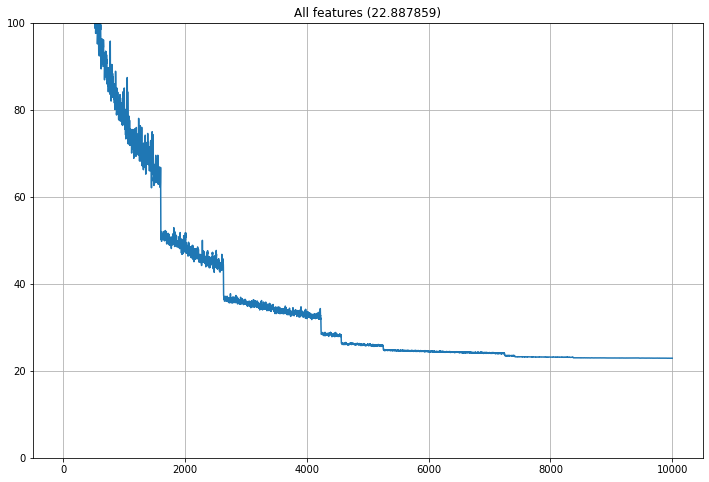

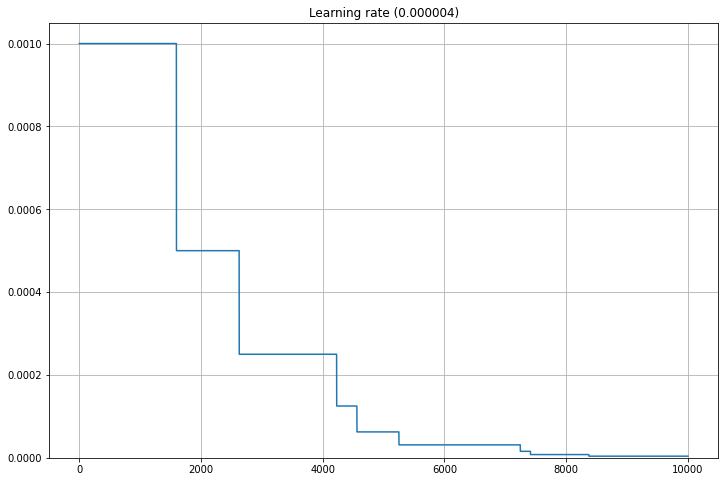

In [13]:
plot_history(autoencoder_all.history, 'All features', ymax=100)
plot_history(autoencoder_all.history, 'Learning rate', key='lr', print_mae=False)

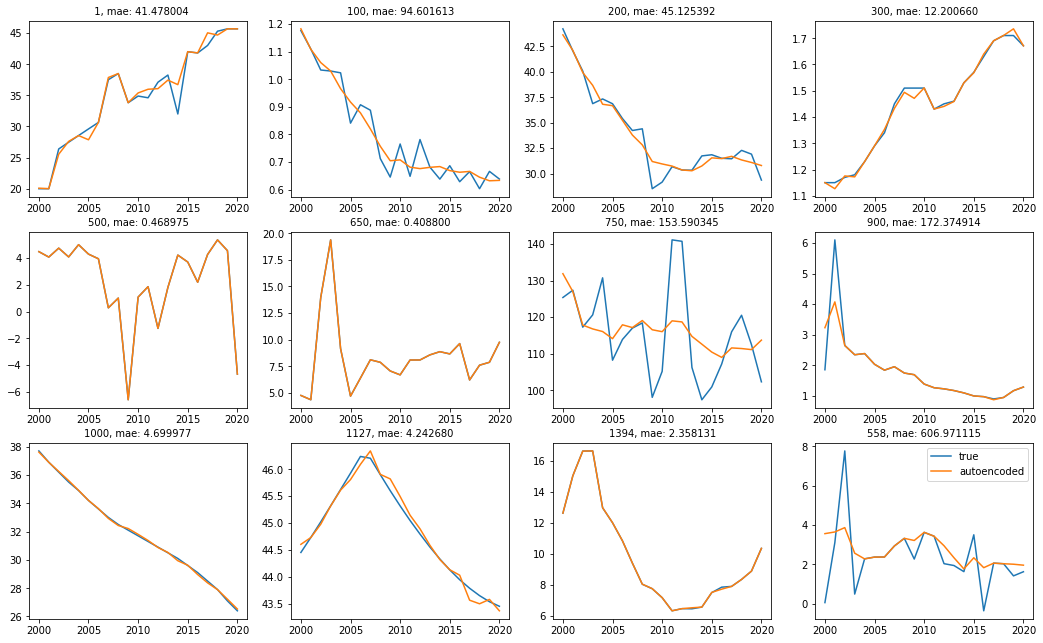

In [14]:
plot_autoencoded(autoencoder_all, X_all)

# Fine-tune for each time series type

In [15]:
for feature, X in list(time_series_dict.items()):
    print('===========================================================================================================================================')
    print(feature)
    print('===========================================================================================================================================')
    
    model_path = f'{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/{feature}'
    autoencoder = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=model_path)
    
    # autoencoder.load_weights(path=ALL_PATH)
    # autoencoder.compile_and_train(X, n_epochs=5000, lr=None, verbose=0, lr_patience=200)
    
    autoencoder.load_weights()
    
    print(f'Loss: {autoencoder.compile_and_evaluate(X):0.6f}. Before fine-tuning: {autoencoder_all.compile_and_evaluate(X):0.6f}')

Access to electricity (% of population)
3/3 [==============================] - 0s 4ms/step - loss: 9.7314
Loss: 7.403048. Before fine-tuning: 9.731409
Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 49.4310
Loss: 35.094475. Before fine-tuning: 49.431023
Exports of goods and services (% of GDP)
3/3 [==============================] - 0s 5ms/step - loss: 39.5420
Loss: 22.755617. Before fine-tuning: 39.542007
Fertility rate, total (births per woman)
3/3 [==============================] - 0s 4ms/step - loss: 15.9594
Loss: 9.120671. Before fine-tuning: 15.959428
Forest area (% of land area)
3/3 [==============================] - 0s 4ms/step - loss: 3.8356
Loss: 1.766344. Before fine-tuning: 3.835633
GDP growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 9.6447
Loss: 6.768373. Before fine-tuning: 9.644747
Inflation, consumer prices (annual %)
3/3 [==============================] - 0s 4ms/step - los

Access to electricity (% of population)
3/3 [==============================] - 0s 4ms/step - loss: 9.7314
Loss: 7.403048. Before fine-tuning: 9.731409


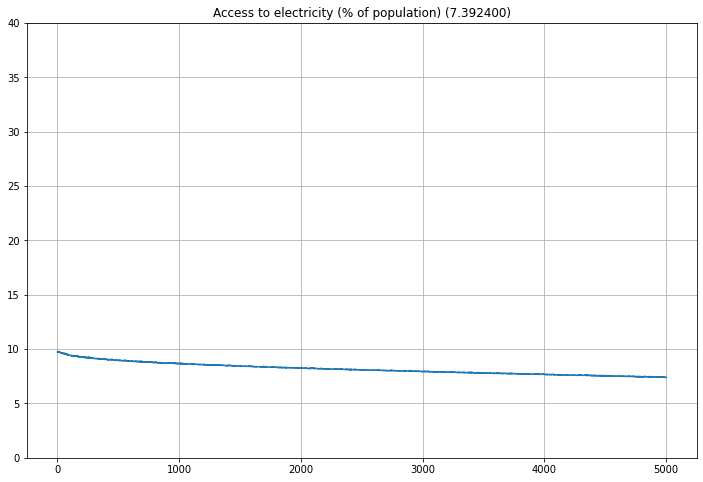

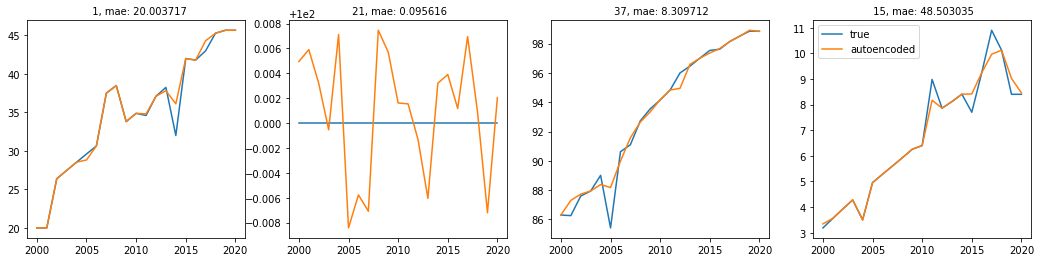

Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 49.4310
Loss: 35.094475. Before fine-tuning: 49.431023


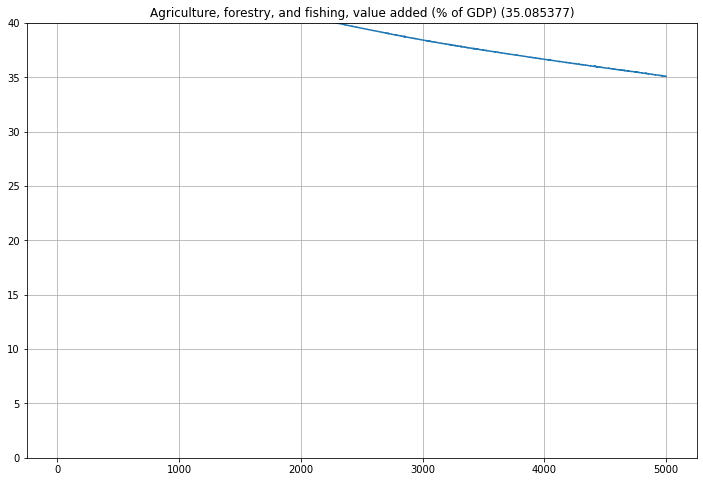

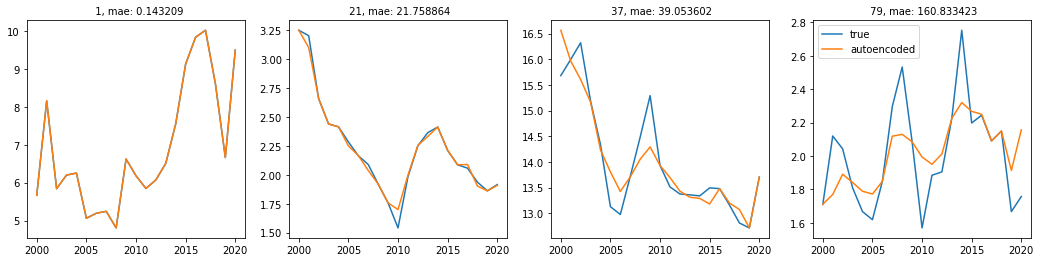

Exports of goods and services (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 39.5420
Loss: 22.755617. Before fine-tuning: 39.542007


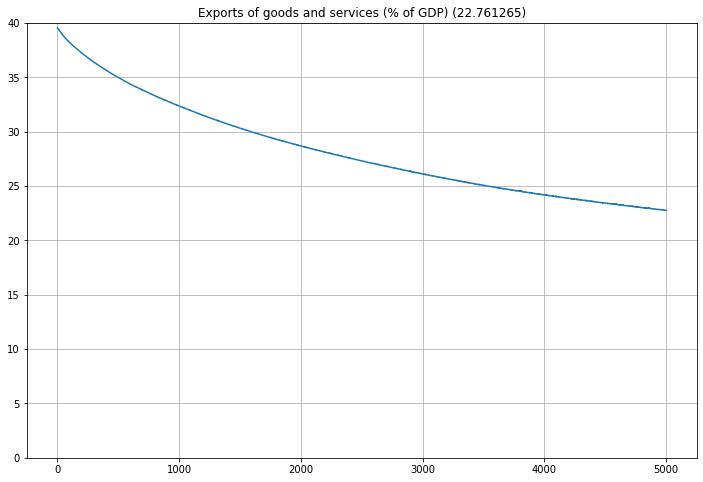

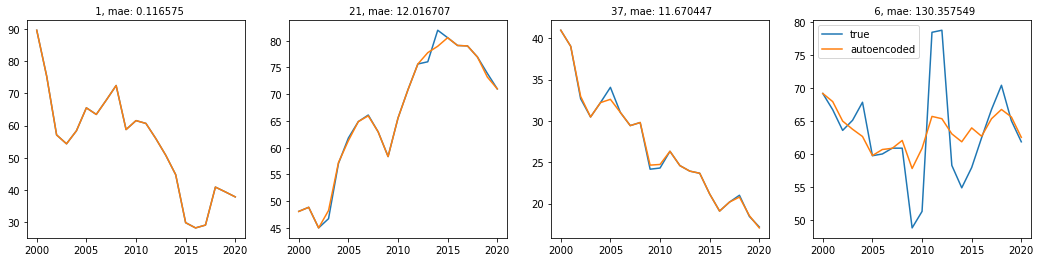

Fertility rate, total (births per woman)
3/3 [==============================] - 0s 3ms/step - loss: 15.9594
Loss: 9.120671. Before fine-tuning: 15.959428


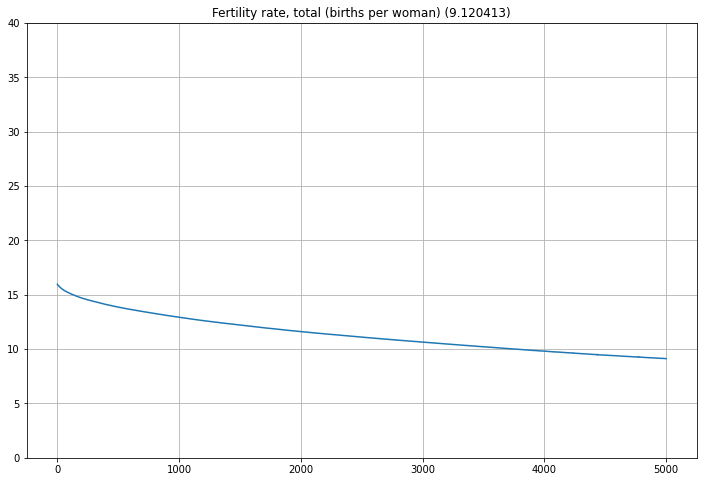

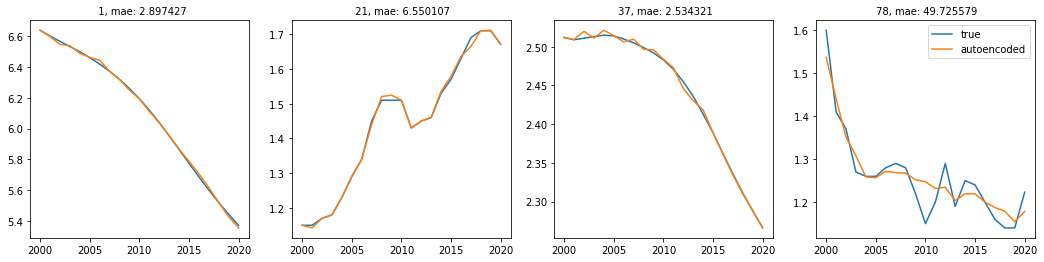

Forest area (% of land area)
3/3 [==============================] - 0s 5ms/step - loss: 3.8356
Loss: 1.766344. Before fine-tuning: 3.835633


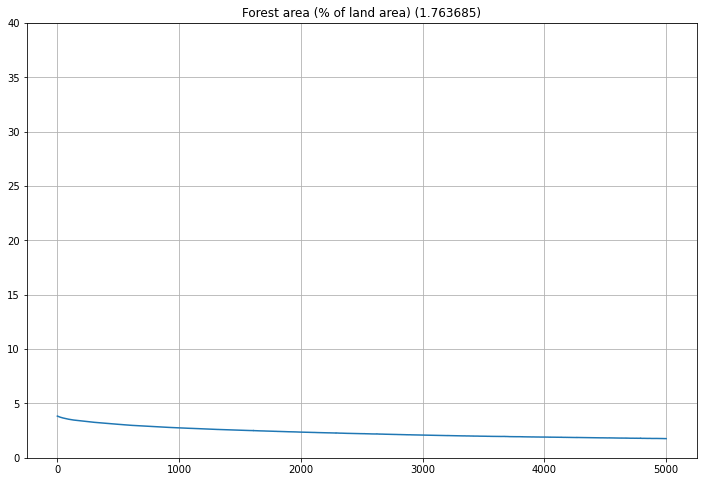

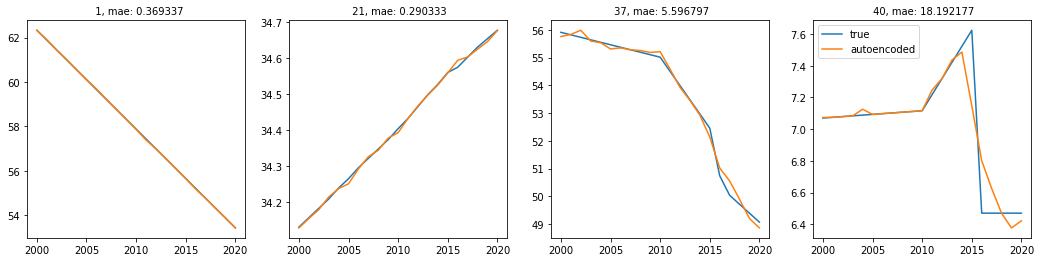

GDP growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 9.6447
Loss: 6.768373. Before fine-tuning: 9.644747


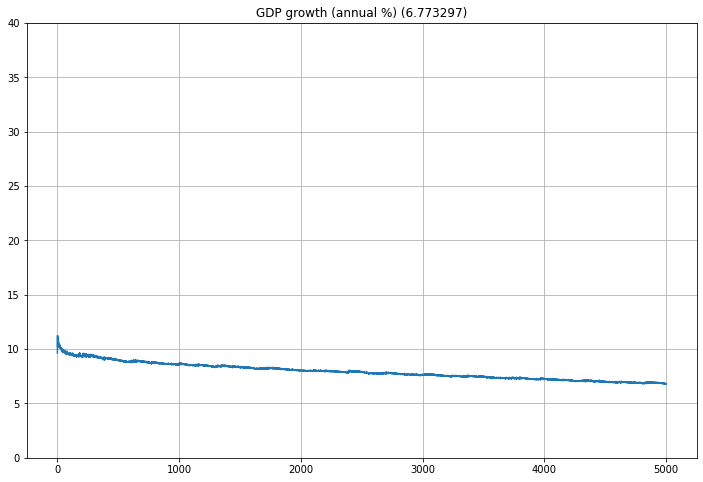

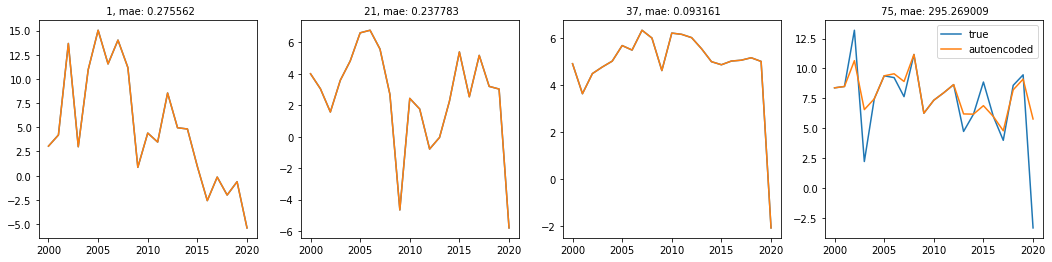

Inflation, consumer prices (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 31.0087
Loss: 24.203203. Before fine-tuning: 31.008749


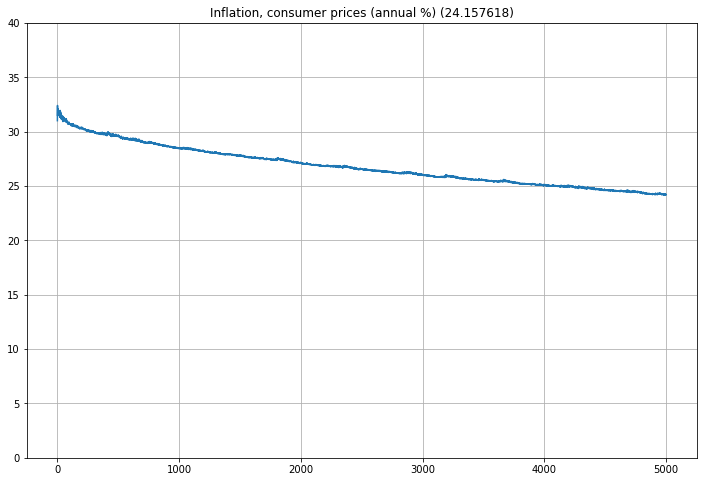

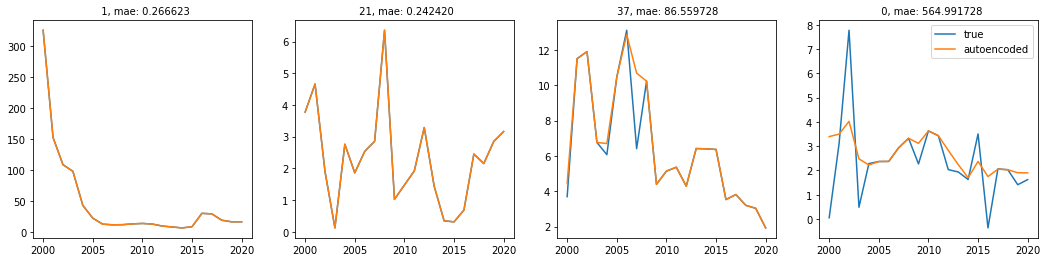

Life expectancy at birth, total (years)
3/3 [==============================] - 0s 3ms/step - loss: 3.0161
Loss: 2.015491. Before fine-tuning: 3.016085


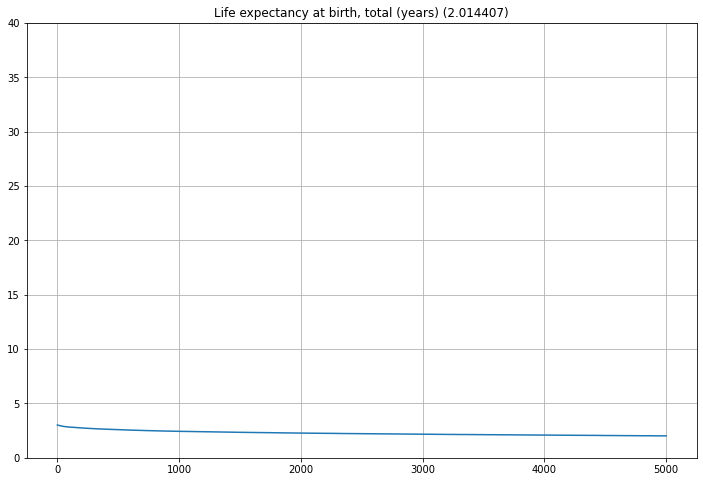

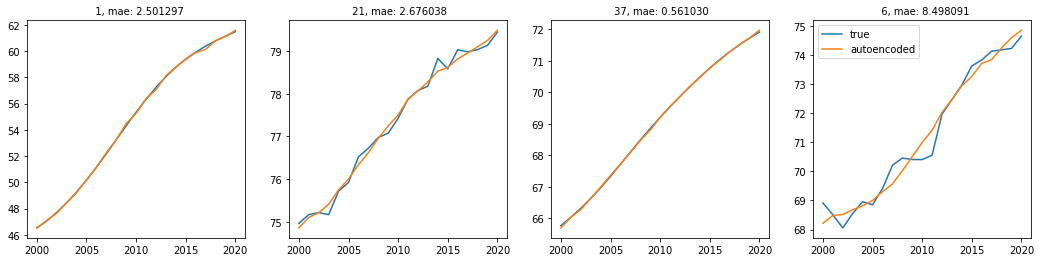

Merchandise trade (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 43.5799
Loss: 27.414545. Before fine-tuning: 43.579926


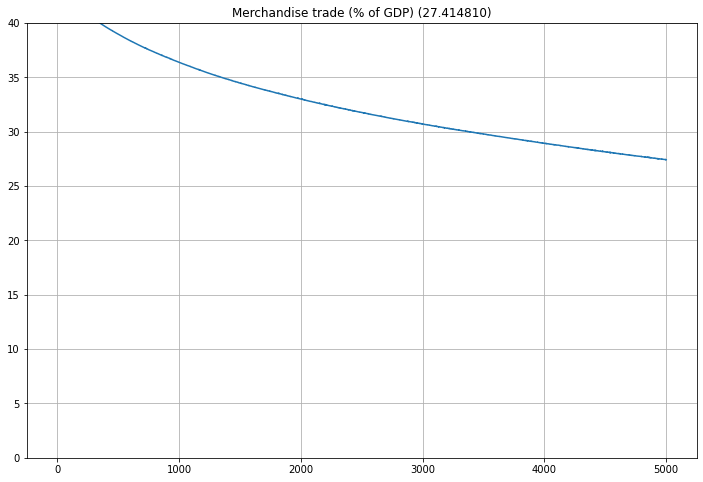

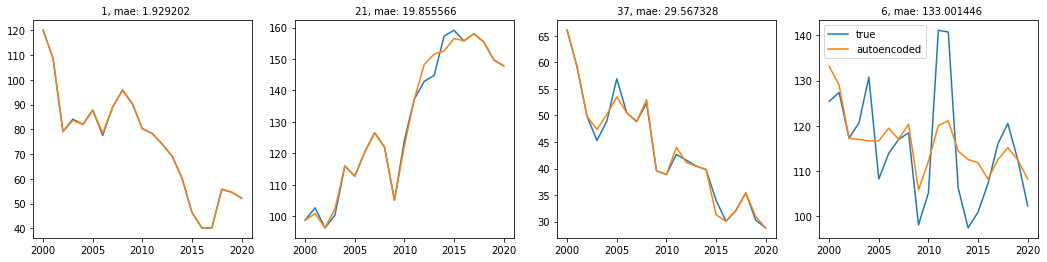

Military expenditure (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 45.7308
Loss: 28.159500. Before fine-tuning: 45.730785


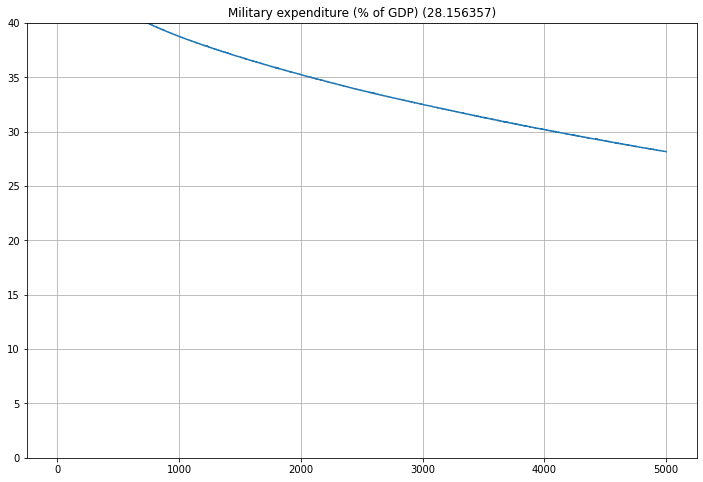

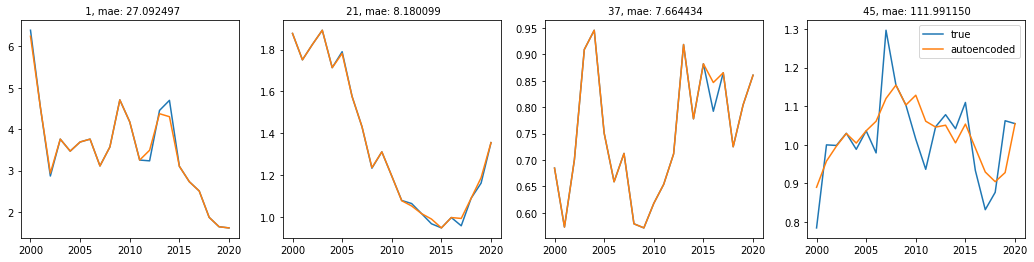

Mortality rate, under-5 (per 1,000 live births)
3/3 [==============================] - 0s 9ms/step - loss: 12.1771
Loss: 7.660544. Before fine-tuning: 12.177124


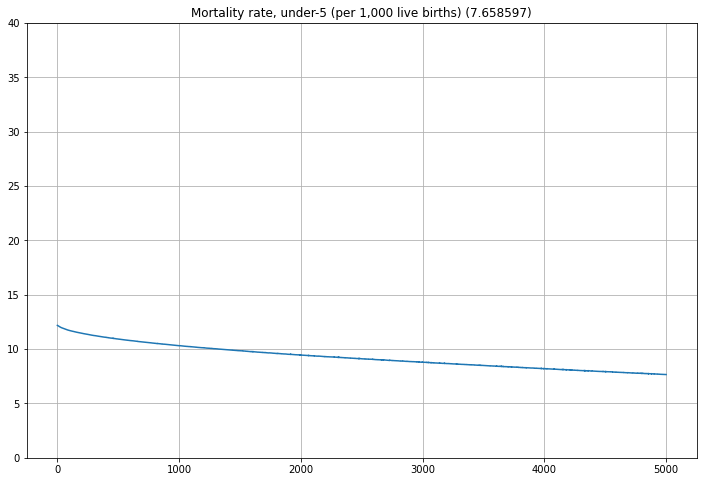

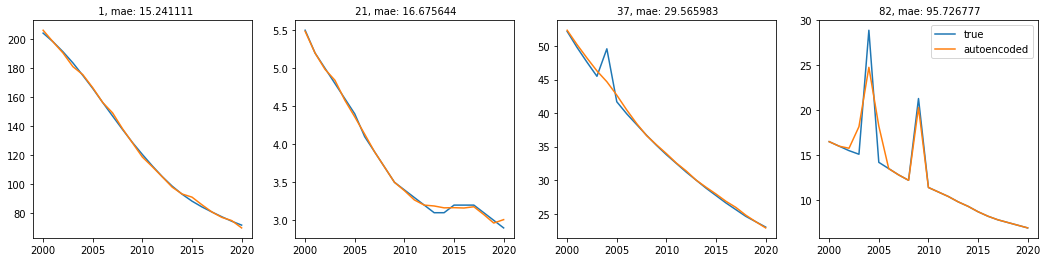

Population growth (annual %)
3/3 [==============================] - 0s 3ms/step - loss: 17.1870
Loss: 9.032059. Before fine-tuning: 17.186958


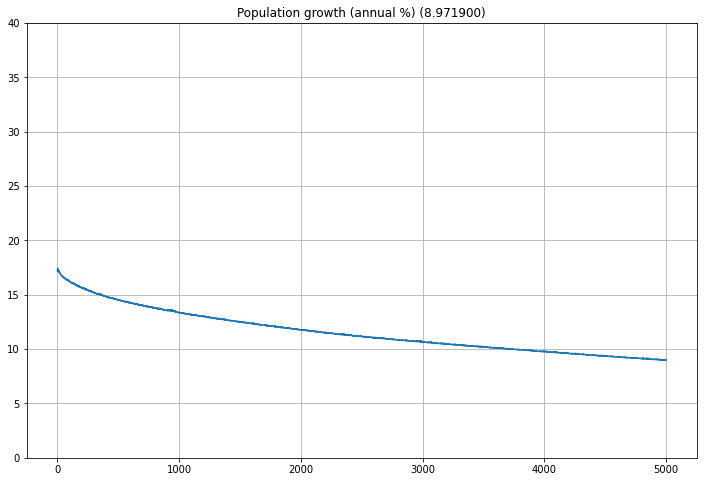

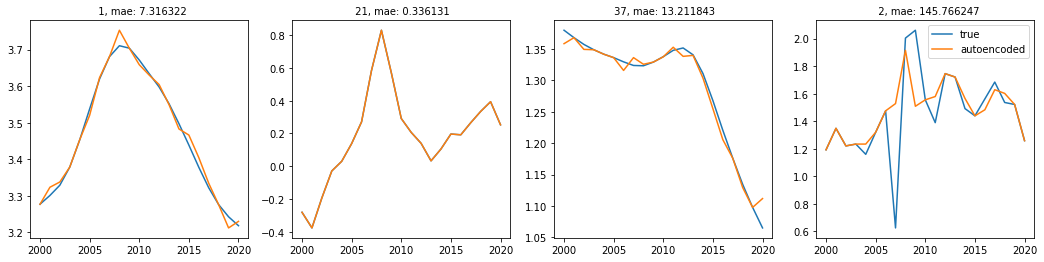

Population in the largest city (% of urban population)
3/3 [==============================] - 0s 4ms/step - loss: 5.1259
Loss: 3.349971. Before fine-tuning: 5.125895


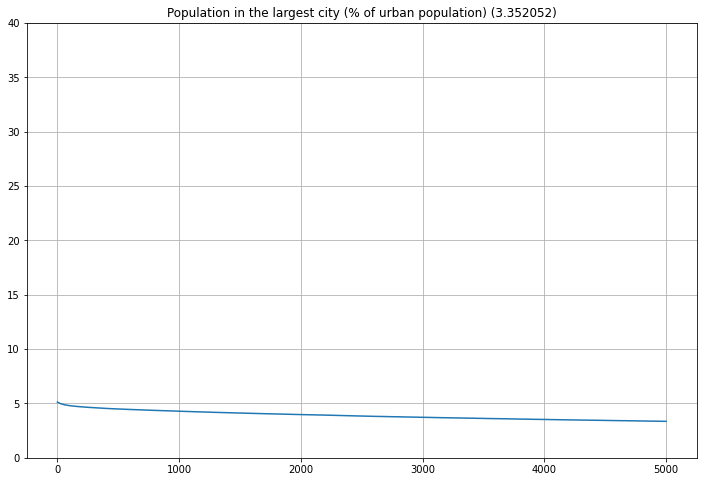

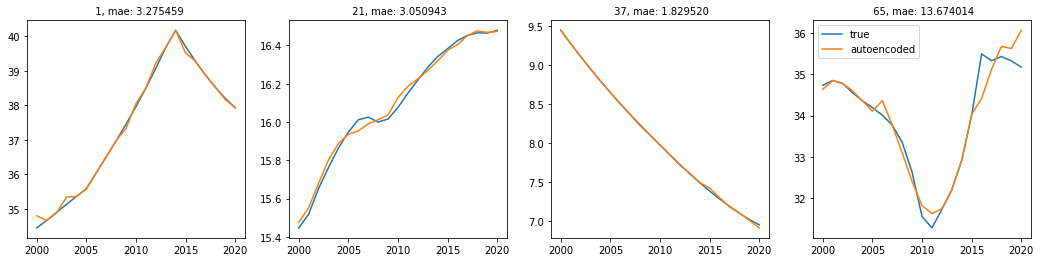

Total natural resources rents (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 25.3985
Loss: 16.229250. Before fine-tuning: 25.398495


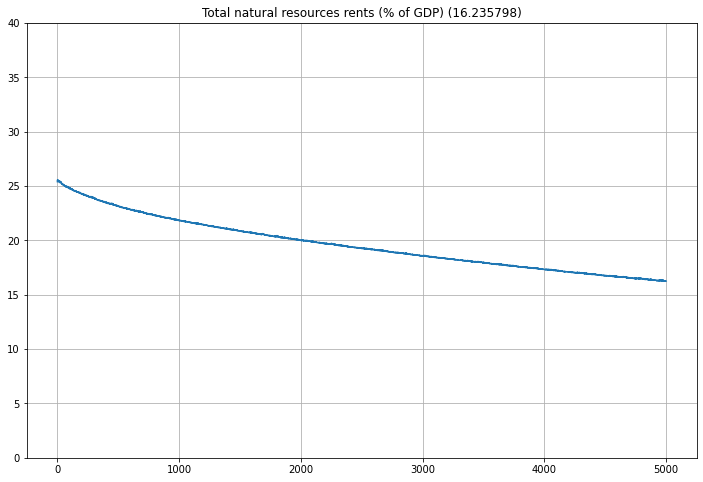

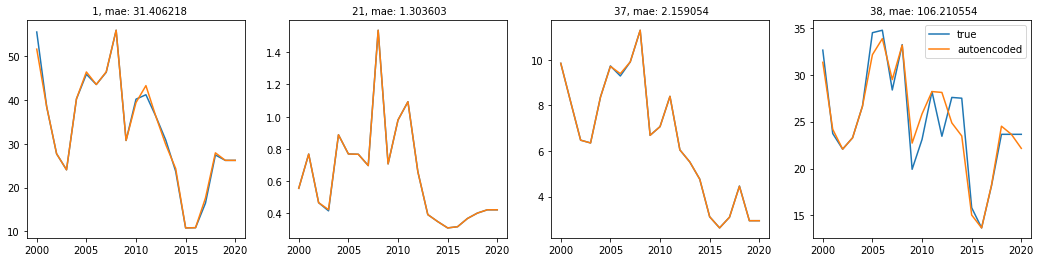

Unemployment, total (% of total labor force) (modeled ILO estimate)
3/3 [==============================] - 0s 3ms/step - loss: 32.0681
Loss: 21.516720. Before fine-tuning: 32.068146


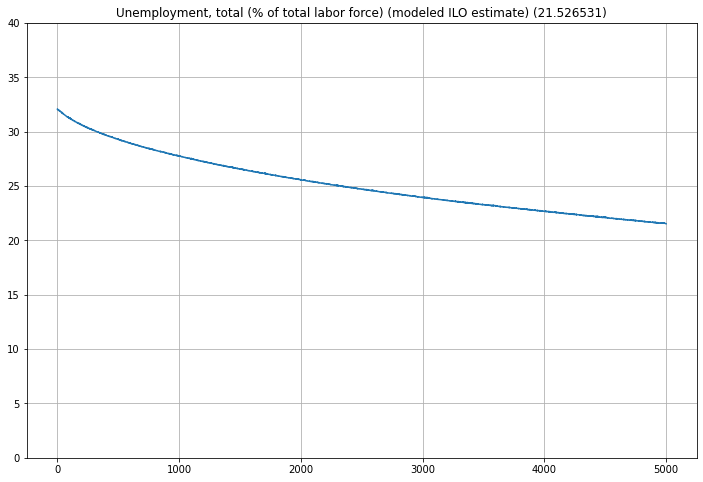

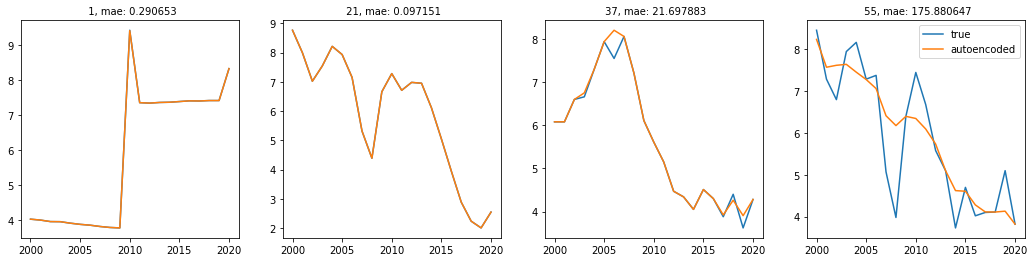

In [16]:
for feature, X in list(time_series_dict.items()):
    print('===========================================================================================================================================')
    print(feature)
    print('===========================================================================================================================================')
    
    model_path = f'{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/{feature}'
    autoencoder = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=model_path).load_weights()
    
    print(f'Loss: {autoencoder.compile_and_evaluate(X):0.6f}. Before fine-tuning: {autoencoder_all.compile_and_evaluate(X):0.6f}')
    
    plot_history(autoencoder.history, feature, ymax=40)
    # plot_history(autoencoder.history, 'Learning rate', key='lr', print_mae=False, figsize=(6, 4))
    plot_autoencoded(autoencoder, X, indices=[1, 21, 37], rows=1, cols=4, figsize=(18, 4))